# **Malicious URL Detection with PySpark**

###**[Big Data Computing Course Project](https://github.com/gtolomei/big-data-computing)**<br> 
A.Y. 2021-2022 <br>
Prof. Gabriele Tolomei <br>
MSc in Computer Science @La Sapienza, University of Rome<br>


**Student**: Clizia Giorgia Manganaro - 2017897<br>
manganaro.2017897@studenti.uniroma1.it



##**Introduction:**


---
Recently, the number of users surfing the internet and interacting with the huge number of existing platforms has increased exponentially and, consequently, the number of cyber crimes they are subjected to. Therefore, the Web has become the main platform for online criminal activities such as malware, phishing, financial fraud, information theft, etc.<br>
**Malicious websites** are the primary attack vector used by cybercriminals to spread malware and archive attackers' objectives. They carry content that might be harmful such as malware or phishing attacks infecting the visitors' smart devices without user interaction with the website such as clicking or downloading.

**How is it possible to protect the user from possible attacks?** <br>

Nowdays there are many ways to prevent these threats and one of the most common is the technique that uses Machine learning algorithms to detect malicious sites and, by doing so, protect the user.

##**Classification task**

---


Designing, implementing and comparing classification models extracting features from the url, allow us to identify and classify four types of urls:
1. benign
2. defacement
3. phishing
4. malware 

The dataset used for the project was taken from [Kaggle](https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset) whose data collection was carried out by combining different sources:
1. [URL dataset (ISCX-URL-2016)](https://www.unb.ca/cic/datasets/url-2016.html) from which benign, phishing, malware and defacement urls have been extracted.
2. [PhishTank](https://www.phishtank.com/developer_info.php) regarding phishing urls
3. [PhishStorm](https://research.aalto.fi/en/datasets/phishstorm-phishing-legitimate-url-dataset) regarding phishing and legitime urls
4. [Faizan GitHub Repo](https://github.com/faizann24/Using-machine-learning-to-detect-malicious-URLs/tree/master/data) to collect benign urls


The selected dataset was created in 2016. Therefore, in order to increase the amount of data, additional phishing URLs were added to the phishtank site from 2017 onwards.

##**0. Preliminaries:**

---



**Declare some global costants**

In [1]:
MOUNT_DIR= '/content/drive'
DATASETS_FOLDER_PATH='/content/drive/MyDrive/Malicious_URL/dataset/'

SLOW_OPERATION: bool = True

PHISHTANK_DATASET_FULL_PATH= f"{DATASETS_FOLDER_PATH}online-valid.csv"
DATASET_PATH_ZIP=f"{DATASETS_FOLDER_PATH}archive.zip"
DATASET_PATH=f"{DATASETS_FOLDER_PATH}malicious_phish.csv"
MODELS_PATH: str = '/content/drive/MyDrive/Malicious_URL/model/'

LOAD_PRETRAINED_MODELS: bool = True

**Install PySpark**

In [3]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 42 kB/s 
     |████████████████████████████████| 199 kB 23.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=61b99d6d462b1e45981c03399f15840ac2930379999a24e676a80e083b500a23
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


**Importing libraries**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import itertools
import re
%matplotlib inline
pd.set_option('display.max_rows',None)
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, mean_squared_error, mean_absolute_error, r2_score


#PySpark
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark import SparkContext, SparkConf
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.mllib.stat import Statistics
from pyspark.sql.functions import col

**Create Spark context and check everything is ok**


In [5]:
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '70G').set('spark.driver.memory', '50G').set("spark.memory.offHeap.enabled",True).set("spark.memory.offHeap.size","16g")

sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [6]:
spark

**Link Colab to  Google Drive**

In [7]:
from google.colab import drive
drive.mount(MOUNT_DIR, force_remount=True)

Mounted at /content/drive


## **1. Dataset Inizialitation**:

---


**Download datasets through wget command and unzip the file**

In [8]:
!wget -P $DATASETS_FOLDER_PATH https://github.com/cliziam/BD-project/raw/main/dataset/archive.zip
!unzip $DATASET_PATH_ZIP -d $DATASETS_FOLDER_PATH

--2022-06-28 14:50:59--  https://github.com/cliziam/BD-project/raw/main/dataset/archive.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cliziam/BD-project/main/dataset/archive.zip [following]
--2022-06-28 14:50:59--  https://raw.githubusercontent.com/cliziam/BD-project/main/dataset/archive.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17748901 (17M) [application/zip]
Saving to: ‘/content/drive/MyDrive/Malicious_URL/dataset/archive.zip.1’

archive.zip.1       100%[===================>]  16.93M  38.1MB/s    in 0.4s    

2022-06-28 14:51:00 (38.1 MB/s) - ‘/content/drive/MyDrive/Malicious_

In [9]:
!wget -P $DATASETS_FOLDER_PATH http://data.phishtank.com/data/online-valid.csv

--2022-06-28 14:51:13--  http://data.phishtank.com/data/online-valid.csv
Resolving data.phishtank.com (data.phishtank.com)... 104.16.101.75, 104.17.177.85, 2606:4700::6810:654b, ...
Connecting to data.phishtank.com (data.phishtank.com)|104.16.101.75|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://data.phishtank.com/data/online-valid.csv [following]
--2022-06-28 14:51:13--  https://data.phishtank.com/data/online-valid.csv
Connecting to data.phishtank.com (data.phishtank.com)|104.16.101.75|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn.phishtank.com/datadumps/verified_online.csv?Expires=1656427883&Signature=oDDB5RBtMB4jz4pc13WuW2cQKWY5ior9TqHQw93YqoBPjuFzvsk7ADXxdVmAQEkMGg-whqHPXSVfZVJGUwKOSGobD1SDY4o1LTQXRQN0Zf6G1iwlye3SBmQ2A6gZAOs~H9lJUwIg0iUylutPVpKpNmKrQvzSNI2hU~FPAO1iWcE4w~0QcCIPqAEA573lnys9NA9IfyuQ2BfeRUmidpuxMHaAg4i60opZ1K89ooWowwPW1pNee5J-vB8ZJUcdkCUMkU1140vXtRvdBswcLNJhRSn~oNruuT4182oiF

**Read datasets file into a Spark Dataframe**


In [10]:
malicious_df = spark.read.csv(DATASET_PATH, 
                              inferSchema="true", 
                              header="true"
                              )

In [11]:
phishtank_df = spark.read.csv(PHISHTANK_DATASET_FULL_PATH, 
                              inferSchema="true", 
                              header="true"
                              )

###**Dataset Description**

The analyzed dataset (`malicious_df`) consists of two columns (url, type) and  it contains up to 651,206  instance.
Regarding the type of url we can identify four different classes: defacement, benign, phishing and malware.

* Website defacement is the unauthorized modification of web pages, including the addition, removal, or alteration of existing content. In the dataset they are websites hosting fraudulent or hidden URL that contains both malicious web pages.

* Phishing is a type of social engineering attack often used to steal personal information.URLs classified as phishing are sites that have the purpose of stealing data from the user.

* Malware (short for “malicious software”) is a file or code, typically delivered over a network, that infects, explores, steals or conducts virtually any behavior an attacker wants. Urls that have been classified as "malware" are sites that have malware inside them.

* "Benign" urls are all other sites that have been rated safe for the user.


The table with the number of instances for each category is proposed below.

Type |count 
---|----
malware|32520
phishing|94108
defacement| 96457
benign|428103

**Check the shape of the loaded datasets**

In [11]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(malicious_df.count(), len(malicious_df.columns)))

The shape of the dataset is 651206 rows by 2 columns


In [12]:
malicious_df.show()

+--------------------+----------+
|                 url|      type|
+--------------------+----------+
|    br-icloud.com.br|  phishing|
|mp3raid.com/music...|    benign|
|bopsecrets.org/re...|    benign|
|http://www.garage...|defacement|
|http://adventure-...|defacement|
|http://buzzfil.ne...|    benign|
|espn.go.com/nba/p...|    benign|
|yourbittorrent.co...|    benign|
|http://www.pashmi...|defacement|
|allmusic.com/albu...|    benign|
|corporationwiki.c...|    benign|
|http://www.ikenmi...|defacement|
|myspace.com/video...|    benign|
|http://www.lebens...|defacement|
|http://www.szabad...|defacement|
|http://larcadelca...|defacement|
|quickfacts.census...|    benign|
|nugget.ca/Article...|    benign|
|uk.linkedin.com/p...|    benign|
|http://www.vnic.c...|defacement|
+--------------------+----------+
only showing top 20 rows



**Print out the schema of the loaded datasets**

In [13]:
malicious_df.printSchema()

root
 |-- url: string (nullable = true)
 |-- type: string (nullable = true)



In [14]:
phishtank_df.printSchema()

root
 |-- phish_id: integer (nullable = true)
 |-- url: string (nullable = true)
 |-- phish_detail_url: string (nullable = true)
 |-- submission_time: timestamp (nullable = true)
 |-- verified: string (nullable = true)
 |-- verification_time: timestamp (nullable = true)
 |-- online: string (nullable = true)
 |-- target: string (nullable = true)



**Print out the types of URLs collected**

In [15]:
malicious_df.groupBy('type').count().orderBy('count').show()

+--------------------+------+
|                type| count|
+--------------------+------+
|                Ð|     1|
|cÔ¡æ>1\bHÇÕd...|     1|
|PhµW\v;XyOy...|     1|
|                null|    15|
|             malware| 32520|
|            phishing| 94108|
|          defacement| 96457|
|              benign|428103|
+--------------------+------+



**Observation:**

Some urls have ambiguous types so the rows that have values that can't be classified as benign, defacement, phishing and malware urls have been removed

**Drop rows that have a type different from malware, defacement, benign or phishing**

In [12]:
malicious_df=malicious_df.filter(malicious_df.type.rlike("malware|phishing|defacement|benign"))

**Select phishtank dataset verified lines that have been inserted since 2017**

In [13]:
phishtank_df=phishtank_df.filter(phishtank_df.verified.rlike("yes")).filter(phishtank_df.submission_time>="2017" )

**Select only the url column on phishtank dataset and add the type phishing column**

In [14]:
columns_todrop=['phish_id', 'phish_detail_url', 'submission_time', 'verified', 'verification_time', 'online', 'target']
phishtank_df=phishtank_df.drop(*columns_todrop).withColumn("type", lit("phishing"))
phishtank_df.count()

13186

**Combine the two datasets into a single DataFrame**

In [15]:
malicious_df = malicious_df.union(phishtank_df)

**Check null values**



In [20]:
for c in malicious_df.columns:
  print("N. of missing values of column `{:s}` = {:d}".format(c, malicious_df.where(col(c).isNull()).count()))

N. of missing values of column `url` = 0
N. of missing values of column `type` = 0


**Check if the dataset has duplicate URLs**

In [21]:
if malicious_df.count() > malicious_df.dropDuplicates().count():
    print('Data has duplicates')

Data has duplicates


**Drop duplicates rows**

In [16]:
malicious_df = malicious_df.dropDuplicates()

**We are dealing with unbalanced dataset!!**

+----------+------+
|      type| count|
+----------+------+
|   malware| 23645|
|defacement| 95308|
|  phishing|107119|
|    benign|428080|
+----------+------+



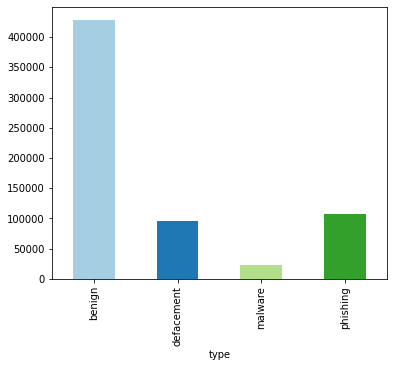

In [23]:
malicious_df.groupBy('type').count().orderBy('count').show()
count_urls_type = malicious_df.select("type").groupBy("type").count().sort("type")
count_urls_type.toPandas().plot.bar(x='type', y='count', figsize=(6,5), legend=False, color=plt.cm.Paired(np.arange(16)))

The dataset is strongly unbalanced, in order to have a classification as truthful as possible, the benign url will be undersampled.

In [17]:
benign_df=malicious_df.filter(malicious_df.type.rlike("benign"))
other_df=malicious_df.filter(malicious_df.type.rlike("malware|phishing|defacement"))
ratio=other_df.count()/benign_df.count()
nonFraudSampleDf = benign_df.sample(False, ratio)
malicious_df=other_df.unionAll(nonFraudSampleDf)

+----------+------+
|      type| count|
+----------+------+
|   malware| 23645|
|defacement| 95308|
|  phishing|107119|
|    benign|226309|
+----------+------+



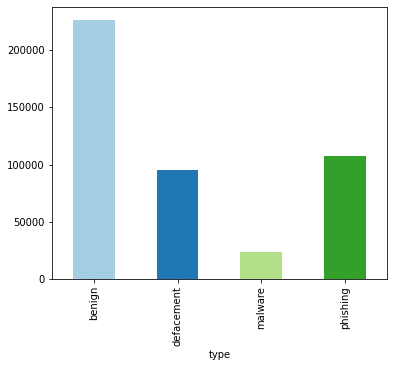

In [25]:
malicious_df.groupBy('type').count().orderBy('count').show()
count_urls_type = malicious_df.select("type").groupBy("type").count().sort("type")
count_urls_type.toPandas().plot.bar(x='type', y='count', figsize=(6,5), legend=False, color=plt.cm.Paired(np.arange(16)))

**Check of the new size of the dataset**

In [26]:
print("The size of the new dataset is {:d}".format(malicious_df.count()))

The size of the new dataset is 452381


**Remove http/https and www**

To make our urls as consistent as possible with each other, it was decided to remove the prefix `www` and the `http/https` protocol from the urls.

In [18]:
malicious_df = malicious_df.withColumn('url', regexp_replace('url', 'www.|http://|https://', ''))

## **2. Feature Engineering**

**Adding some extra features**

New features have been added to the dataset.

The new features are:
* `len_url`,
* `len_domain`,
* `vowels_cnt`,
* `alpha_cnt`, 
* `numeric_cnt`, 
* `puncs_cnt`,
* `dot_cnt`, 
* `hyphen_cnt`, 
* `underline_cnt`,
* `slash_cnt`,
* `questionmark_cnt`,
* `equal_cnt`,
* `at_cnt`,
* `and_cnt`,
* `exclamation_cnt`,
* `space_cnt`,
* `tilde_cnt`,
* `comma_cnt`,
* `plus_cnt`,
* `asterisk_cnt`,
* `ashtag_cnt`,
* `dollar_cnt`,
* `percent_cnt`,
* `is_short`,
* `domain_in_ip`,
* `email_in_url`,
* `server_client_domain`



In [19]:
def short(domain):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      domain)
    if match:
        return True
    else:
        return False

In [20]:
def add_feature(df):
  column={"dot_cnt":'\.' , 
      "hyphen_cnt":'\-' , 
      "underline_cnt":'\_', 
      "slash_cnt":'\/', 
      "questionmark_cnt":'\?' , 
      "equal_cnt":'\=',
      "at_cnt":'\@', 
      "and_cnt":"\&",
      "exclamation_cnt":'\!' , 
      "space_cnt": '\ ',
      "tilde_cnt": '\~', 
      "comma_cnt":'\,', 
      "plus_cnt": '\+', 
      "asterisk_cnt": '\*', 
      "hashtag_cnt": '\#', 
      "dollar_cnt": '\$', 
      "percent_cnt": '%'
  } 

  #extract domain
  domain = udf(lambda domain: domain.split("/")[0], StringType()) 
  df=df.withColumn("domain", domain(df.url))
  
  '''
  numerical features
  [len_url, len_domain, vowels_cnt, alpha_cnt, numeric_cnt, puncs_cnt, dot_cnt, 
  hyphen_cnt, underline_cnt, slash_cnt, ]

  '''
  
  #url length
  df=df.withColumn("len_url", length("url"))

  #domain length
  df=df.withColumn("len_domain", length("domain"))
  
  #count the number of vowels in url
  df=df.withColumn("vowels_cnt", length(regexp_replace("url","[^aeiouAEIOU]", "")))
  
  #count the number of alphabet letters (a-z) in url
  df=df.withColumn("alpha_cnt", length(regexp_replace("url","[^a-zA-Z]", "")))
  
  #count the number of digits in url
  df=df.withColumn("numeric_cnt",  length(regexp_replace("url","[^0-9]", "")))
  
  #count the punctuation characters
  df=df.withColumn("puncs_cnt", (col("len_url")-(col("alpha_cnt") + col("numeric_cnt"))))
  
  #count the URL signs
  for x, y in column.items():
    df=df.withColumn(x, length("url") - length(regexp_replace("url",y, "")))
  
  '''
  categorical features
  [is_short, domain_in_ip, email_in_url, server_client_domain]
  '''
  #check if a url is short
  is_short = udf(lambda sh: 1 if short(sh) else 0, IntegerType()) 
  df=df.withColumn("is_short", is_short(df.domain))

  #check if URL domain is in IP address format
  domain_in_ip = udf(lambda dom: 1 if dom.replace('.', '').isnumeric() else 0, IntegerType()) 
  df=df.withColumn("domain_in_ip", domain_in_ip(df.domain))

  #check if email is present in url
  email_in_url = udf(lambda url:1 if re.findall(r'[\w\.-]+@[\w\.-]+', url) else 0, IntegerType()) 
  df=df.withColumn("email_in_url", email_in_url(df.url))

  #check if the words server or client is present in domain
  server_client_domain = udf(lambda dom:1 if "server".lower() in dom.lower() or "client" in dom.lower() else 0, IntegerType()) 
  df=df.withColumn("server_client_domain", server_client_domain(df.domain))

  return df

In [21]:
full_df=add_feature(malicious_df)

In [31]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(full_df.count(), len(full_df.columns)))

The shape of the dataset is 452381 rows by 30 columns


In [32]:
full_df.printSchema()

root
 |-- url: string (nullable = true)
 |-- type: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- len_url: integer (nullable = true)
 |-- len_domain: integer (nullable = true)
 |-- vowels_cnt: integer (nullable = true)
 |-- alpha_cnt: integer (nullable = true)
 |-- numeric_cnt: integer (nullable = true)
 |-- puncs_cnt: integer (nullable = true)
 |-- dot_cnt: integer (nullable = true)
 |-- hyphen_cnt: integer (nullable = true)
 |-- underline_cnt: integer (nullable = true)
 |-- slash_cnt: integer (nullable = true)
 |-- questionmark_cnt: integer (nullable = true)
 |-- equal_cnt: integer (nullable = true)
 |-- at_cnt: integer (nullable = true)
 |-- and_cnt: integer (nullable = true)
 |-- exclamation_cnt: integer (nullable = true)
 |-- space_cnt: integer (nullable = true)
 |-- tilde_cnt: integer (nullable = true)
 |-- comma_cnt: integer (nullable = true)
 |-- plus_cnt: integer (nullable = true)
 |-- asterisk_cnt: integer (nullable = true)
 |-- hashtag_cnt: integer (null

In [22]:
full_df=full_df.drop("url", "domain")

In [34]:
full_df.drop("type").describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
len_url,452381,56.7655317088914,45.58524358781963,1,7806
len_domain,452381,17.001226841976123,10.75951922251197,0,285
vowels_cnt,452381,15.194459979530528,10.676733880243056,0,1115
alpha_cnt,452381,43.40265837866754,33.47513060186148,0,6250
numeric_cnt,452381,5.235434291006917,11.319167497816752,0,1337
puncs_cnt,452381,8.127439039216943,7.136646041717815,0,269
dot_cnt,452381,2.077436939217164,1.3605234851146533,0,42
hyphen_cnt,452381,1.4136889038222207,2.8007183265132807,0,211
underline_cnt,452381,0.39316859019278,1.0696842670877102,0,64


## **3.  Exploration Data Analysis**

---



In [23]:
NUMERICAL_FEATURES = ['len_url', 
                      'len_domain', 
                      'vowels_cnt', 
                      'alpha_cnt', 
                      'numeric_cnt', 
                      'puncs_cnt', 
                      'dot_cnt', 
                      'hyphen_cnt', 
                      'underline_cnt', 
                      'slash_cnt', 
                      'questionmark_cnt', 
                      'equal_cnt', 
                      'at_cnt', 
                      'and_cnt', 
                      'exclamation_cnt', 
                      'space_cnt', 
                      'tilde_cnt', 
                      'comma_cnt', 
                      'plus_cnt', 
                      'asterisk_cnt', 
                      'hashtag_cnt', 
                      'dollar_cnt', 
                      'percent_cnt'                      
                      ]

CATEGORICAL_FEATURES = ['is_short', 
                        'domain_in_ip', 
                        'email_in_url', 
                        'server_client_domain'
                       ]

TARGET_VARIABLE = 'type'  

In [24]:
full_pandas=full_df.toPandas()

###**Analysis of Data Distributions: Numerical Features**


**Visualizing the distribution of the Numerical Features**<br>

From the histograms below is possible to observe that the numeric features are skewed towards the left.

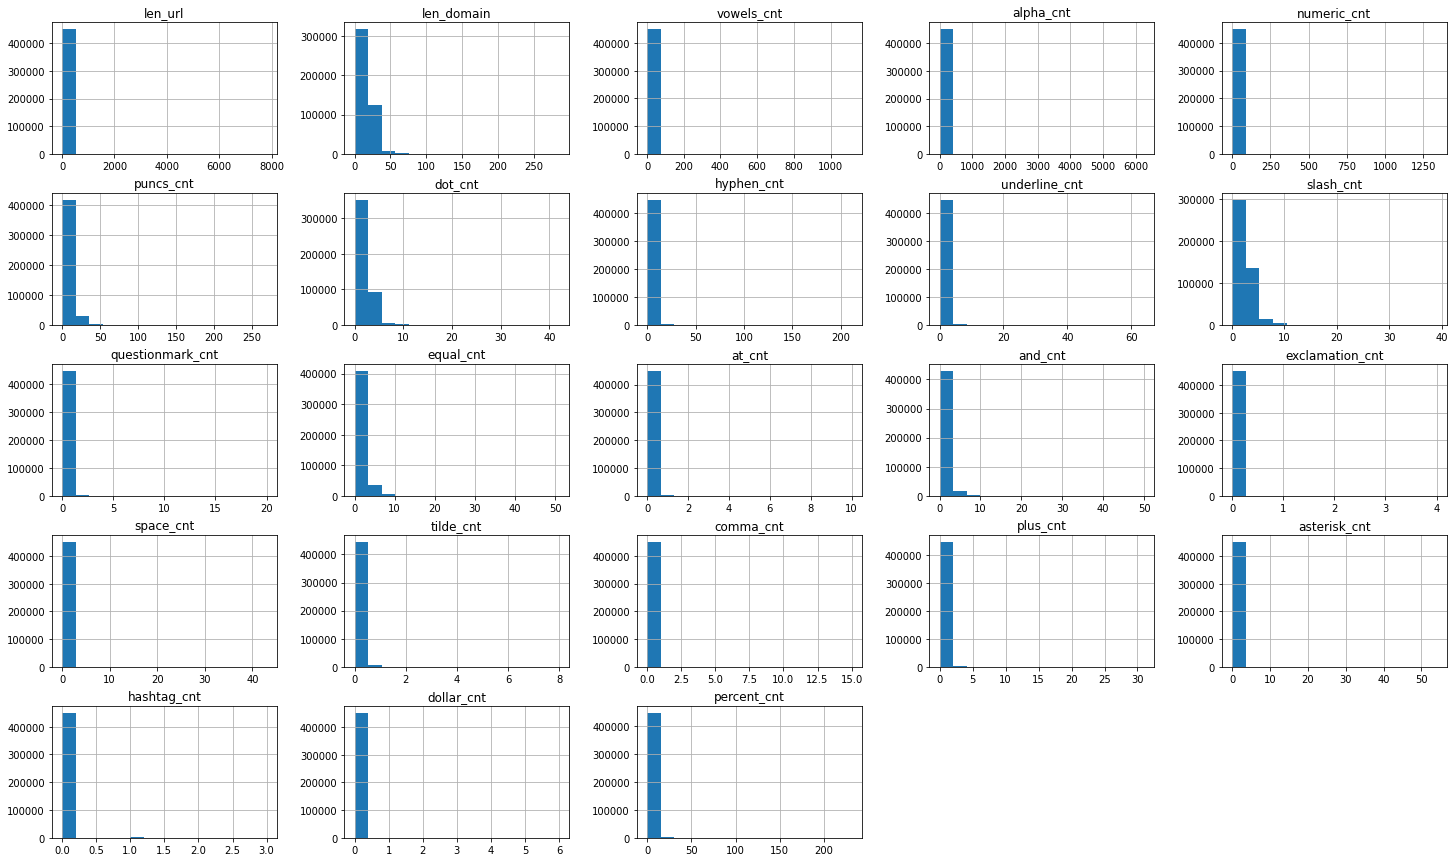

In [37]:
full_pandas[NUMERICAL_FEATURES].hist(bins=15,figsize=(25,15));

### **Analysis of Data Distributions: Categorical Features**


**1. Histograms of individual categorical features**


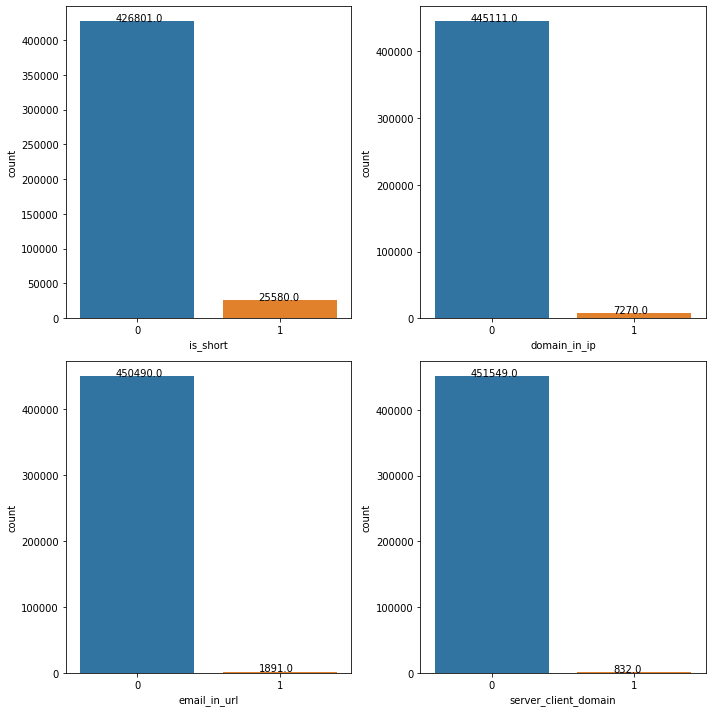

In [38]:
fig = plt.figure(figsize=(10, 10))
i = 1
for col in CATEGORICAL_FEATURES:
    plt.subplot(2, 2, i)
    ax= sns.countplot(x=col, data=full_pandas)
    for p in ax.patches:
      ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    i += 1

plt.tight_layout()

None of categorical features are balanced.

**Correlation Matrix**


In [39]:
def compute_correlation_matrix(df, method='pearson'):
    df_rdd = df.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat,
                    columns=df.columns, 
                    index=df.columns)
    return corr_mat_df


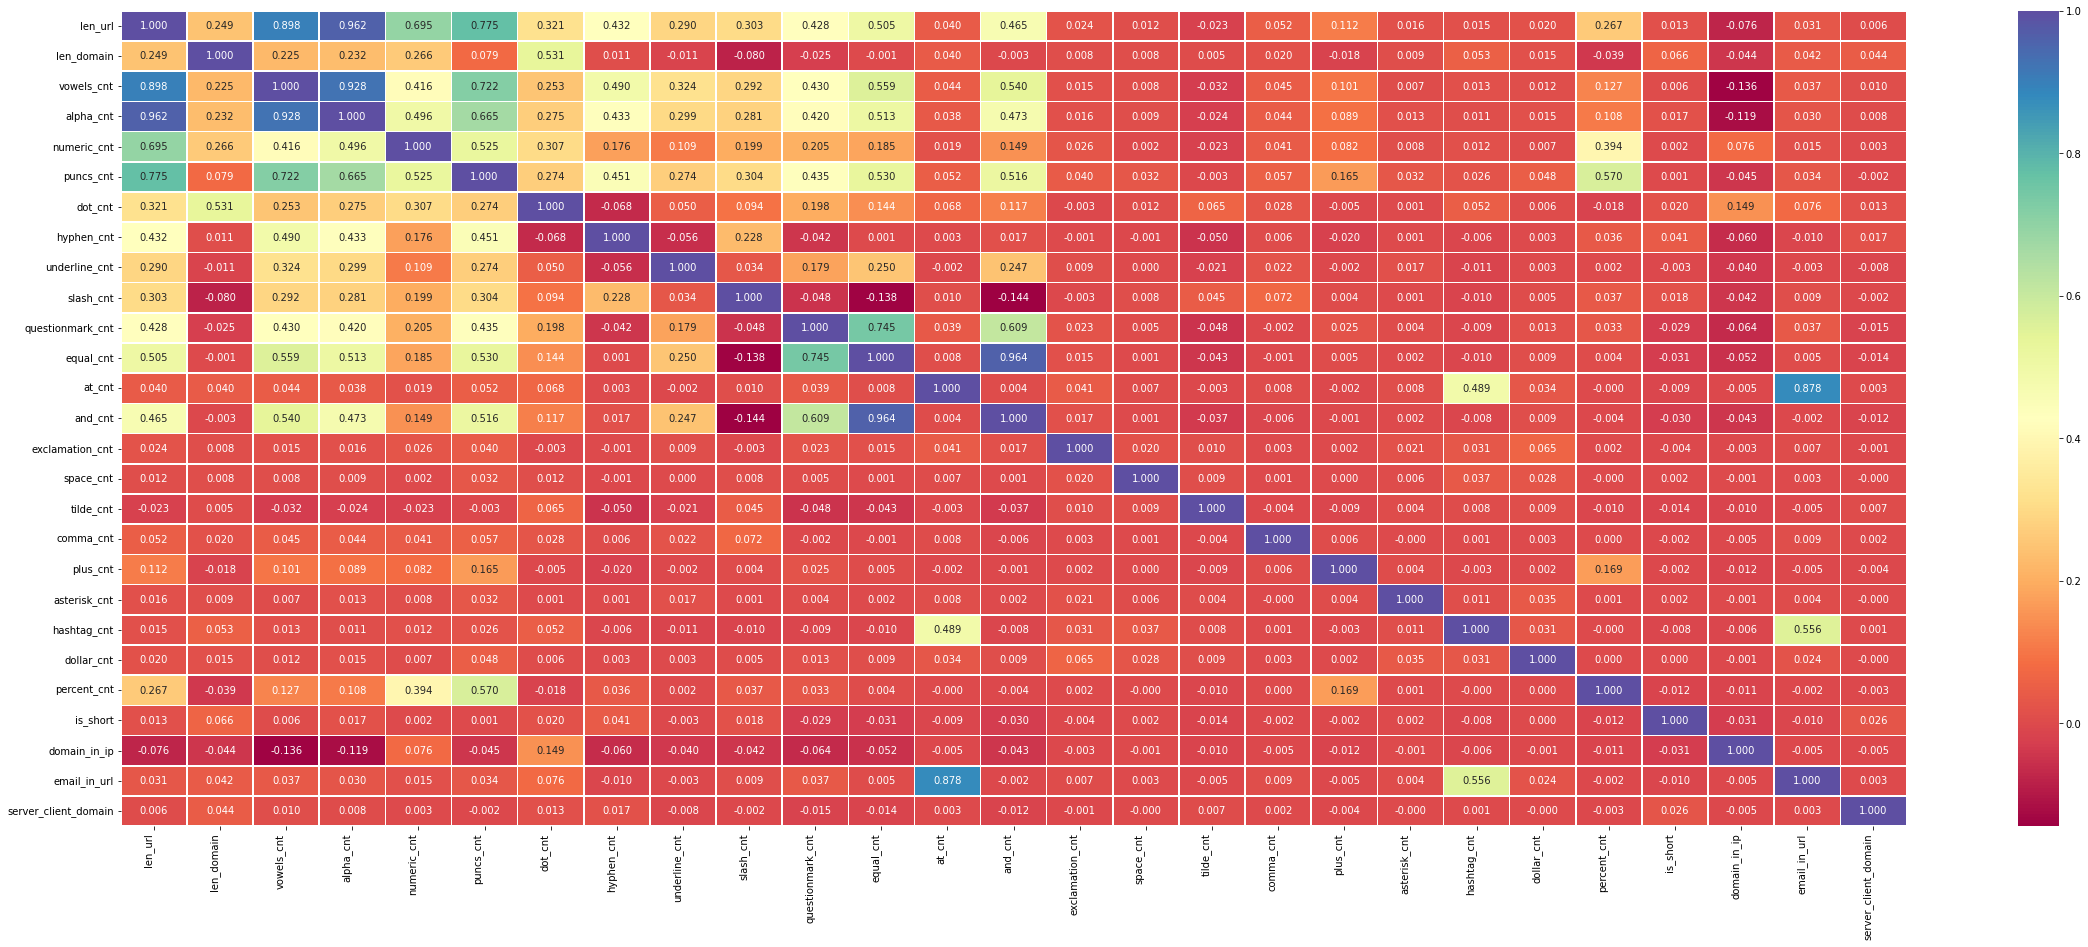

In [40]:
fig, ax = plt.subplots(figsize=(40, 15))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

sns.heatmap(
  compute_correlation_matrix(full_df.drop('type')),
  annot=True, 
  linewidths=.5,fmt='.3f', cmap="Spectral"
)

plt.show()

####**Observations**

From the correlation matrix above it's easy to note that:
* `vowels_cnt` and` alpha_cnt` have a strong relationship with `len_url` since their correlation coefficient is 0.899 and 0.955 respectively
*`vowels_cnt` `alpha_cnt` are closely related to each other with a coefficient of 0.939
* `and_cnt` and` equal_cnt` have a strong correlation with a coefficient of 0.957
* `email_in_url` `at_cnt` are closely related to each other with a coefficient of 0.883.

So, in order to prepare our classification model it's better to remove the columns `alpha_cnt` `equal_cnt` and` and_cnt` that have correlation coefficient > 0.9.

**Drop vowels_cnt, alpha_cnt, equal_cnt,  and_cnt columns** 

In [25]:
full_df=full_df.drop('alpha_cnt', 'equal_cnt', 'and_cnt')
NUMERICAL_FEATURES.remove('alpha_cnt')
NUMERICAL_FEATURES.remove('equal_cnt')
NUMERICAL_FEATURES.remove('and_cnt')

In [26]:
full_df.printSchema()

root
 |-- type: string (nullable = true)
 |-- len_url: integer (nullable = true)
 |-- len_domain: integer (nullable = true)
 |-- vowels_cnt: integer (nullable = true)
 |-- numeric_cnt: integer (nullable = true)
 |-- puncs_cnt: integer (nullable = true)
 |-- dot_cnt: integer (nullable = true)
 |-- hyphen_cnt: integer (nullable = true)
 |-- underline_cnt: integer (nullable = true)
 |-- slash_cnt: integer (nullable = true)
 |-- questionmark_cnt: integer (nullable = true)
 |-- at_cnt: integer (nullable = true)
 |-- exclamation_cnt: integer (nullable = true)
 |-- space_cnt: integer (nullable = true)
 |-- tilde_cnt: integer (nullable = true)
 |-- comma_cnt: integer (nullable = true)
 |-- plus_cnt: integer (nullable = true)
 |-- asterisk_cnt: integer (nullable = true)
 |-- hashtag_cnt: integer (nullable = true)
 |-- dollar_cnt: integer (nullable = true)
 |-- percent_cnt: integer (nullable = true)
 |-- is_short: integer (nullable = true)
 |-- domain_in_ip: integer (nullable = true)
 |-- email_

##**4. The Learning Pipeline**

---

**ML Pipeline** <br>
Since our categorical variables are Boolean values (0-1) it will not be necessary to transform them.
Therefore, it is necessary to define a pipeline which will be used later in the models we are going to use.
1. `StringIndexer` define the target_variable in "label" and convert the textual data to numeric data keeping the categorical context.
2. `VectorAssembler`: is it useful to combine numerical_features and categorical_features together into a single vector column and named it as features
3. `ScandardScaler` when` scaler: bool` is set to true it Standardizes features by removing the mean and scaling to unit std using column summary statistics on the samples in the training set.

In [27]:
from pyspark.ml.classification import LogisticRegressionModel,DecisionTreeClassificationModel, RandomForestClassificationModel, GBTClassificationModel
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier,GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

In [28]:
def pipeline(train, 
              numerical_features, 
              categorical_features, 
              target_variable, 
              with_std=True,
              with_mean=True,
              scaler=True):

  

    label_indexer = StringIndexer(inputCol=target_variable, outputCol="label")
    assembler = VectorAssembler(inputCols=numerical_features+categorical_features, outputCol="features")

    if scaler:
      scaler_vect = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), withStd=with_std, withMean=with_mean)
      stages =  [label_indexer] + [assembler] + [scaler_vect]
    else:
      stages =  [label_indexer] + [assembler]

    pipeline = Pipeline(stages=stages)
    transformer = pipeline.fit(train)
    df_transformed = transformer.transform(train)
    return transformer,df_transformed


## **5. Binary Classification  Malicious Urls**

---

In this classification task all malicious URLs have been grouped in order to perform a binary classification between malicious and safe sites.

So, `bm_df` will only have  two types of urls:
1. malicious urls (malware, phishing, defacement)
2. benign urls

In [45]:
bm_df = full_df.withColumn("type", when(F.col("type") == "malware","1")
      .when(F.col("type") == "phishing","1")
      .when(F.col("type") == "defacement","1")
      .otherwise("0"))

+----+------+
|type| count|
+----+------+
|   1|226072|
|   0|226309|
+----+------+



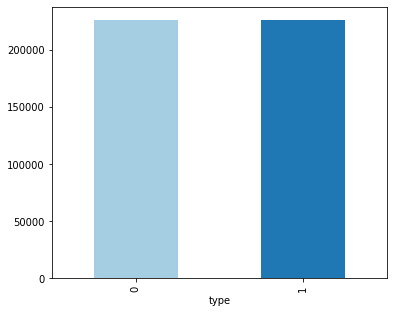

In [46]:
bm_df.groupBy('type').count().orderBy('count').show()
count_urls_type = bm_df.select("type").groupBy("type").count().sort("type")
count_urls_type.toPandas().plot.bar(x='type', y='count', figsize=(6,5), legend=False, color=plt.cm.Paired(np.arange(16)))

**Dataset Splitting: Training vs. Test Set**

Before proceeding with any other operation, we will split our dataset into two portions:

* training set (e.g., accounting for 80% of the total number of instances);
* test set (e.g., accounting for the remaining 20% of instances)

In [47]:
train_df, test_df = bm_df.randomSplit([0.8, 0.2], seed=42)

In [48]:
train_df.groupBy('type').count().orderBy('count').show()
test_df.groupBy('type').count().orderBy('count').show()

+----+------+
|type| count|
+----+------+
|   1|180614|
|   0|181031|
+----+------+

+----+-----+
|type|count|
+----+-----+
|   0|45278|
|   1|45458|
+----+-----+



In [49]:
experiments = {
      "logistic_regression_malben_no_std":("log_reg_malben_no_std", LogisticRegression, False),
      "logistic_regression_malben_std": ("log_reg_malben_std",LogisticRegression, True),
      "decision_tree_malben_no_std": ( "decision_tree_malben_no_std", DecisionTreeClassifier, False),
      "decision_tree_malben_std": ("decision_tree_malben_std",  DecisionTreeClassifier, True),
      "random_forest_malben_no_std": ("random_forest_malben_no_std", RandomForestClassifier, False),
      "random_forest_malben_std": ("random_forest_malben_std",  RandomForestClassifier, True),
      "gradient_malben_no_std": ("gradient_malben_no_std", GBTClassifier, False),
      "gradient_malben_std": ("gradient_malben_std",  GBTClassifier, True),
  }

In [50]:
def metrics(predictions):
  y_true = predictions.select("label")
  y_true = y_true.toPandas()
  y_pred = predictions.select("prediction")
  y_pred = y_pred.toPandas()
  confusion_matrix_lr = confusion_matrix(y_true, y_pred, labels=[0.0, 1.0])
  plt.figure()
  plot_confusion_matrix(confusion_matrix_lr, classes=[0.0, 1.0], title='Confusion matrix')
  plt.show()

In [51]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix without normalization")
  
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [52]:
def evaluate_model_binary(predictions, metric="areaUnderROC"):
    evaluator = BinaryClassificationEvaluator(metricName=metric)
    return evaluator.evaluate(predictions)

In [53]:
def metrics_calculation(y_test, pred):
  precision = precision_score(y_test, pred, average = "macro")
  recall = recall_score(y_test, pred, average = "macro")
  accuracy = accuracy_score(y_test, pred)
  f1score = (2 * (precision * recall))/(precision + recall)
  print('Accuracy : {}'.format(accuracy))
  print('Precision : {}'.format(precision))
  print('Recall : {}'.format(recall))
  print('F1-score : {}'.format(f1score))

Starting training logistic_regression_malben_no_std
metrics: logistic_regression_malben_no_std
Confusion matrix without normalization


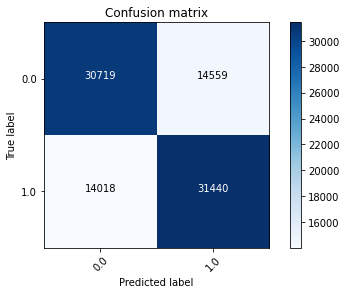

Accuracy : 0.6850533415623347
Precision : 0.6850753479591554
Recall : 0.6850402741007038
F1-score : 0.6850578105809983
Test Under ROC Curve (ROC AUC):: 0.759
Area Under Precision-Recall Curve: 0.761
________________________________
Starting training logistic_regression_malben_std
metrics: logistic_regression_malben_std
Confusion matrix without normalization


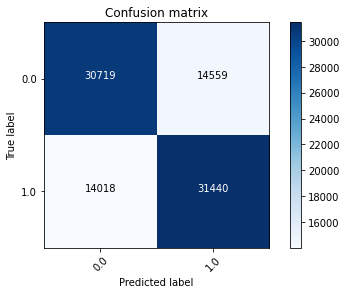

Accuracy : 0.6850533415623347
Precision : 0.6850753479591554
Recall : 0.6850402741007038
F1-score : 0.6850578105809983
Test Under ROC Curve (ROC AUC):: 0.759
Area Under Precision-Recall Curve: 0.761
________________________________
Starting training decision_tree_malben_no_std
metrics: decision_tree_malben_no_std
Confusion matrix without normalization


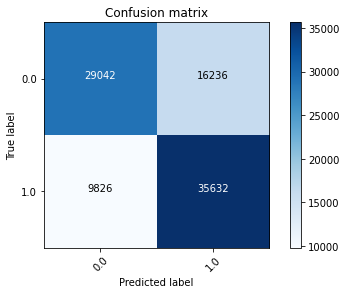

Accuracy : 0.7127711162052548
Precision : 0.7170851322074618
Recall : 0.7126298423405601
F1-score : 0.7148505454680736
Test Under ROC Curve (ROC AUC):: 0.651
Area Under Precision-Recall Curve: 0.594
________________________________
Starting training decision_tree_malben_std
metrics: decision_tree_malben_std
Confusion matrix without normalization


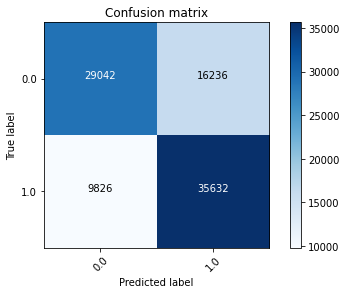

Accuracy : 0.7127711162052548
Precision : 0.7170851322074618
Recall : 0.7126298423405601
F1-score : 0.7148505454680736
Test Under ROC Curve (ROC AUC):: 0.651
Area Under Precision-Recall Curve: 0.594
________________________________
Starting training random_forest_malben_no_std
metrics: random_forest_malben_no_std
Confusion matrix without normalization


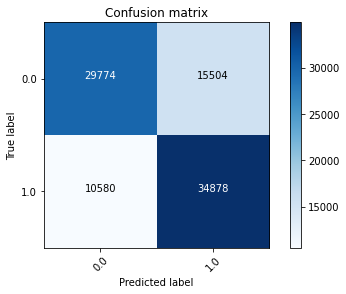

Accuracy : 0.712528654558279
Precision : 0.7150456698069648
Recall : 0.7124198685463711
F1-score : 0.7137303541158223
Test Under ROC Curve (ROC AUC):: 0.803
Area Under Precision-Recall Curve: 0.830
________________________________
Starting training random_forest_malben_std
metrics: random_forest_malben_std
Confusion matrix without normalization


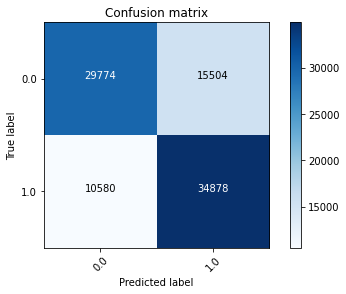

Accuracy : 0.712528654558279
Precision : 0.7150456698069648
Recall : 0.7124198685463711
F1-score : 0.7137303541158223
Test Under ROC Curve (ROC AUC):: 0.803
Area Under Precision-Recall Curve: 0.830
________________________________
Starting training gradient_malben_no_std
metrics: gradient_malben_no_std
Confusion matrix without normalization


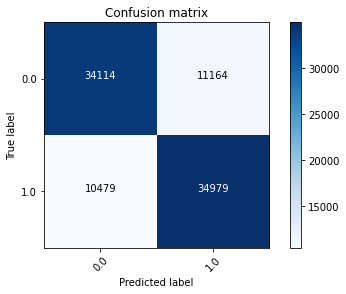

Accuracy : 0.7614728442955387
Precision : 0.7615322187480291
Recall : 0.7614569292645417
F1-score : 0.7614945721453049
Test Under ROC Curve (ROC AUC):: 0.851
Area Under Precision-Recall Curve: 0.865
________________________________
Starting training gradient_malben_std
metrics: gradient_malben_std
Confusion matrix without normalization


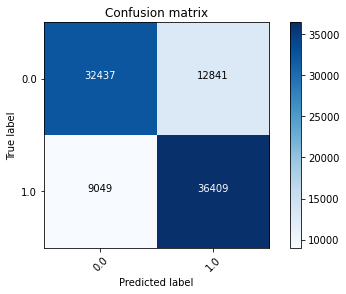

Accuracy : 0.7587506612590372
Precision : 0.7605736297560843
Recall : 0.758666806360925
F1-score : 0.7596190214159675
Test Under ROC Curve (ROC AUC):: 0.852
Area Under Precision-Recall Curve: 0.866
________________________________


In [54]:
RUN_EXPERIMENTS = True 
if RUN_EXPERIMENTS:
  for experiment in experiments:
    model_folder, model, standardized = experiments[experiment]
    column_features = "std_features" if standardized else "features"
    transformer, train_df_transformed = pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE, scaler=standardized)
    train_df_transformed = train_df_transformed.select([column_features, "label"])
    
    print("Starting training " + experiment)

    if model == LogisticRegression:
      training = model(featuresCol = column_features, labelCol = "label", maxIter=500)
      
    else:
      training = model(featuresCol = column_features, labelCol = "label")

    training_model = training.fit(train_df_transformed)
    test_df_transformed = transformer.transform(test_df)
    test_df_transformed = test_df_transformed.select([column_features, "label"])
    predictions = training_model.transform(test_df_transformed)

    print("metrics: " + experiment)
    metrics(predictions)
    metrics_calculation(predictions.select("label").toPandas(), predictions.select("prediction").toPandas())
    print('Test Under ROC Curve (ROC AUC):: {:.3f}'.format(evaluate_model_binary(predictions)))
    print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model_binary(predictions, metric="areaUnderPR")))
    
    training_model.write().overwrite().save(MODELS_PATH + model_folder)
    print("________________________________")

In [55]:
logistic_regression_experiments = [("log_reg_malben_no_std", False),("log_reg_malben_std", True)]
decision_tree_experiments = [("decision_tree_malben_no_std", False),("decision_tree_malben_std", True)]
random_forest_experiments = [("random_forest_malben_no_std", False),("random_forest_malben_std", True)]
gradient_experiments = [("gradient_malben_no_std", False),("gradient_malben_std", True)]

In [56]:
trasformer_not_scaled, train_df_not_scaled_transformed = pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES,TARGET_VARIABLE, scaler=False)
trasformer_scaled, train_df_not_transformed = pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES,TARGET_VARIABLE, scaler=True)

test_df_not_scaled = trasformer_not_scaled.transform(test_df).select(["features", "label"])
test_df_scaled = trasformer_scaled.transform(test_df).select(["std_features", "label"])

**Logistic Regression**

metrics: log_reg_malben_no_std
Confusion matrix without normalization


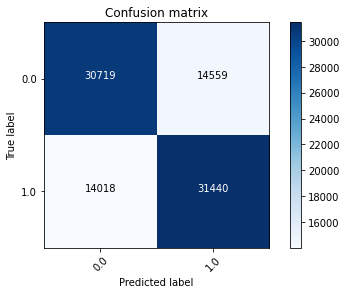

Accuracy : 0.6850533415623347
Precision : 0.6850753479591554
Recall : 0.6850402741007038
F1-score : 0.6850578105809983
Test Under ROC Curve (ROC AUC):: 0.759
Area Under Precision-Recall Curve: 0.761
________________________________
metrics: log_reg_malben_std
Confusion matrix without normalization


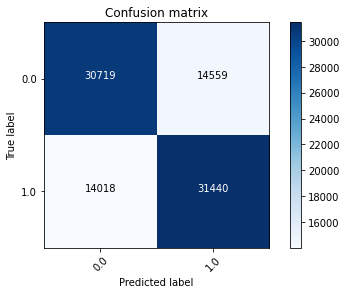

Accuracy : 0.6850533415623347
Precision : 0.6850753479591554
Recall : 0.6850402741007038
F1-score : 0.6850578105809983
Test Under ROC Curve (ROC AUC):: 0.759
Area Under Precision-Recall Curve: 0.761
________________________________


In [57]:
for exp in logistic_regression_experiments:
  experiment, standardized = exp
  model = LogisticRegressionModel.load(MODELS_PATH + experiment)
  
  if not standardized :
    test_dataset = test_df_not_scaled
  else:
    test_dataset = test_df_scaled
  
  predictions = model.transform(test_dataset)
  print("metrics: " + experiment)
  metrics(predictions)
  metrics_calculation(predictions.select("label").toPandas(), predictions.select("prediction").toPandas())
  print('Test Under ROC Curve (ROC AUC): {:.3f}'.format(evaluate_model_binary(predictions)))
  print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model_binary(predictions, metric="areaUnderPR")))
  print("________________________________")

**Decision Tree**

Metrics decision_tree_malben_no_std
Confusion matrix without normalization


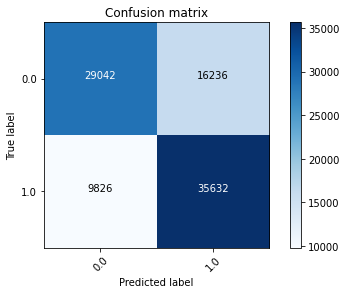

Accuracy : 0.7127711162052548
Precision : 0.7170851322074618
Recall : 0.7126298423405601
F1-score : 0.7148505454680736
Test Under ROC Curve (ROC AUC):: 0.651
Area Under Precision-Recall Curve: 0.594
________________________________
Metrics decision_tree_malben_std
Confusion matrix without normalization


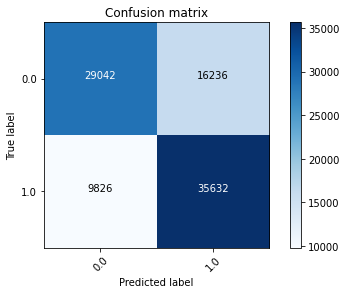

Accuracy : 0.7127711162052548
Precision : 0.7170851322074618
Recall : 0.7126298423405601
F1-score : 0.7148505454680736
Test Under ROC Curve (ROC AUC):: 0.651
Area Under Precision-Recall Curve: 0.594
________________________________


In [58]:
for exp in decision_tree_experiments:
  experiment, standardized = exp
  model = DecisionTreeClassificationModel.load(MODELS_PATH + experiment)
  
  if not standardized :
    test_dataset = test_df_not_scaled
  else:
    test_dataset = test_df_scaled
  
  predictions = model.transform(test_dataset)

  print("Metrics " + experiment)
  metrics(predictions)
  metrics_calculation(predictions.select("label").toPandas(), predictions.select("prediction").toPandas())
  print('Test Under ROC Curve (ROC AUC): {:.3f}'.format(evaluate_model_binary(predictions)))
  print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model_binary(predictions, metric="areaUnderPR")))
  print("________________________________")

**Random Forest**

Metrics random_forest_malben_no_std
Confusion matrix without normalization


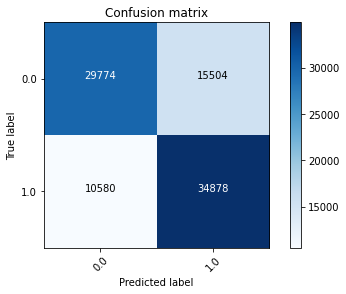

Accuracy : 0.712528654558279
Precision : 0.7150456698069648
Recall : 0.7124198685463711
F1-score : 0.7137303541158223
Test Under ROC Curve (ROC AUC):: 0.803
Area Under Precision-Recall Curve: 0.830
________________________________
Metrics random_forest_malben_std
Confusion matrix without normalization


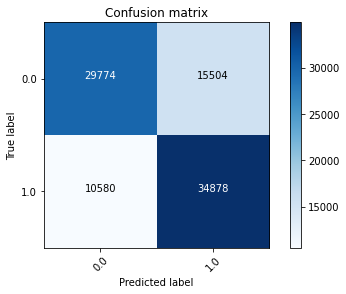

Accuracy : 0.712528654558279
Precision : 0.7150456698069648
Recall : 0.7124198685463711
F1-score : 0.7137303541158223
Test Under ROC Curve (ROC AUC):: 0.803
Area Under Precision-Recall Curve: 0.830
________________________________


In [59]:
for exp in random_forest_experiments:
  experiment, standardized = exp
  model = RandomForestClassificationModel.load(MODELS_PATH + experiment)
  
  if not standardized :
    test_dataset = test_df_not_scaled
  else:
    test_dataset = test_df_scaled
  
  predictions = model.transform(test_dataset)
  
  print("Metrics " + experiment)
  metrics(predictions)
  metrics_calculation(predictions.select("label").toPandas(), predictions.select("prediction").toPandas())
  print('Test Under ROC Curve (ROC AUC): {:.3f}'.format(evaluate_model_binary(predictions)))
  print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model_binary(predictions, metric="areaUnderPR")))
  print("________________________________")

**Gradient Boosted Decision Tree**


Metrics gradient_malben_no_std
Confusion matrix without normalization


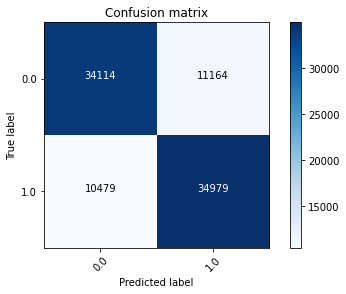

Accuracy : 0.7614728442955387
Precision : 0.7615322187480291
Recall : 0.7614569292645417
F1-score : 0.7614945721453049
Test Under ROC Curve (ROC AUC):: 0.851
Area Under Precision-Recall Curve: 0.865
________________________________
Metrics gradient_malben_std
Confusion matrix without normalization


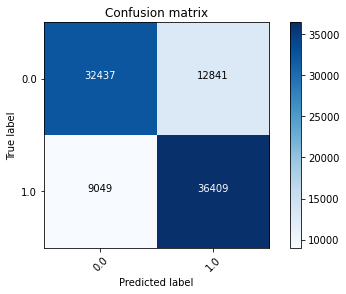

Accuracy : 0.7587506612590372
Precision : 0.7605736297560843
Recall : 0.758666806360925
F1-score : 0.7596190214159675
Test Under ROC Curve (ROC AUC):: 0.852
Area Under Precision-Recall Curve: 0.866
________________________________


In [60]:
for exp in gradient_experiments:
  experiment, standardized = exp
  model = GBTClassificationModel.load(MODELS_PATH + experiment)
  
  if not standardized :
    test_dataset = test_df_not_scaled
  else:
    test_dataset = test_df_scaled
  
  predictions = model.transform(test_dataset)
  
  print("Metrics " + experiment)
  metrics(predictions)
  metrics_calculation(predictions.select("label").toPandas(), predictions.select("prediction").toPandas())
  print('Test Under ROC Curve (ROC AUC): {:.3f}'.format(evaluate_model_binary(predictions)))
  print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model_binary(predictions, metric="areaUnderPR")))
  print("________________________________")

## **6. Multiclass Classification**

---

**Dataset Splitting: Training vs. Test Set**

As we have already seen, the dataset is unbalanced and this might negatively affects the classification, indeed the challenge of working with unbalanced datasets is that machine learning techniques will often ignore this issue, leading to poor performance in the "minority" class. 

Random Stratified Sampling has been applied to overcome this problem. 
Splitting into train and test set with **Random Stratified Sampling**. A "Stratification" of the data is performed on the basis of the four groups (ie, defacement, malware, phishing, benign) and within each group a simple random sampling is applied.

In [29]:
def_train , def_test= full_df.where(F.col('type')=="defacement").randomSplit([0.8,0.2], seed=1234)
mal_train, mal_test= full_df.where(F.col('type')=="malware").randomSplit([0.8,0.2], seed=1234)
phish_train, phish_test= full_df.where(F.col('type')=="phishing").randomSplit([0.8,0.2], seed=1234)
ben_train, ben_test=full_df.where(F.col('type')=="benign").randomSplit([0.8,0.2], seed=1234)

train_dfs=[def_train, mal_train, phish_train, ben_train]
test_dfs=[def_test, mal_test, phish_test, ben_test]

train_df= reduce(DataFrame.unionAll, train_dfs)
test_df= reduce(DataFrame.unionAll, test_dfs)

In [62]:
train_df.groupBy('type').count().orderBy('count').show()
test_df.groupBy('type').count().orderBy('count').show()

+----------+------+
|      type| count|
+----------+------+
|   malware| 18925|
|defacement| 76343|
|  phishing| 85865|
|    benign|181239|
+----------+------+

+----------+-----+
|      type|count|
+----------+-----+
|   malware| 4720|
|defacement|18965|
|  phishing|21254|
|    benign|45070|
+----------+-----+



In [30]:
experiments = {
      "logistic_regression_multiclass_no_std":("log_reg_multiclass_no_std", LogisticRegression, False),
      "logistic_regression_multiclass_std": ("log_reg_multiclass_std",LogisticRegression, True),
      "decision_tree_multiclass_no_std": ( "decision_tree_multiclass_no_std", DecisionTreeClassifier, False),
      "decision_tree_multiclass_std": ("decision_tree_multiclass_std",  DecisionTreeClassifier, True),
      "random_forest_multiclass_no_std": ("random_forest_multiclass_no_std", RandomForestClassifier, False),
      "random_forest_multiclass_std": ("random_forest_multiclass_std",  RandomForestClassifier, True),
  }

In [31]:
def metrics_calculation_multiclass(y_test, pred):
  precision = precision_score(y_test, pred, average = "macro")
  recall = recall_score(y_test, pred, average = "macro")
  f1score = (2 * (precision * recall))/(precision + recall)
  print('Precision : {}'.format(precision))
  print('Recall : {}'.format(recall))
  print('F1-score : {}'.format(f1score))

In [32]:
RUN_EXPERIMENTS = True
if RUN_EXPERIMENTS:
  for experiment in experiments:
    model_folder, model, standardized = experiments[experiment]
    column_features = "std_features" if standardized else "features"
    transformer, train_df_transformed = pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE, scaler=standardized)
    train_df_transformed = train_df_transformed.select([column_features, "label"])
    
    print("Starting training " + experiment)

    if model == LogisticRegression:
      training = model(featuresCol = column_features, labelCol = "label", maxIter=100)
      
    else:
      training = model(featuresCol = column_features, labelCol = "label")

    training_model = training.fit(train_df_transformed)
    test_df_transformed = transformer.transform(test_df)
    test_df_transformed = test_df_transformed.select([column_features, "label"])
    predictions = training_model.transform(test_df_transformed)

    print("Metrics " + experiment)
    metrics_calculation_multiclass(predictions.select("label").toPandas(), predictions.select("prediction").toPandas())
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    print('Test Under ROC Curve (ROC AUC): {:.3f}'.format(evaluator.evaluate(predictions)))
    training_model.write().overwrite().save(MODELS_PATH + model_folder)
    print("________________________________")

Starting training logistic_regression_multiclass_no_std
Metrics logistic_regression_multiclass_no_std
Precision : 0.7186640741276016
Recall : 0.5275949984701769
F1-score : 0.608482745565208
Test Under ROC Curve (ROC AUC): 0.599
________________________________
Starting training logistic_regression_multiclass_std
Metrics logistic_regression_multiclass_std
Precision : 0.7186640741276016
Recall : 0.5275949984701769
F1-score : 0.608482745565208
Test Under ROC Curve (ROC AUC): 0.599
________________________________
Starting training decision_tree_multiclass_no_std
Metrics decision_tree_multiclass_no_std
Precision : 0.8404950605436488
Recall : 0.5282826472213823
F1-score : 0.6487816875473493
Test Under ROC Curve (ROC AUC): 0.608
________________________________
Starting training decision_tree_multiclass_std
Metrics decision_tree_multiclass_std
Precision : 0.8406657542991001
Recall : 0.5282120024932913
F1-score : 0.6487792489906122
Test Under ROC Curve (ROC AUC): 0.608
_______________________

In [68]:
logistic_regression_experiments = [("log_reg_multiclass_no_std", False),("log_reg_multiclass_std", True)]
decision_tree_experiments = [("decision_tree_multiclass_no_std", False),("decision_tree_multiclass_std", True)]
random_forest_experiments = [("random_forest_multiclass_no_std", False),("random_forest_multiclass_std", True)]

In [69]:
trasformer_not_scaled, train_df_not_scaled_transformed = pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES,TARGET_VARIABLE, scaler=False)
trasformer_scaled, train_df_not_transformed = pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES,TARGET_VARIABLE, scaler=True)

test_df_not_scaled = trasformer_not_scaled.transform(test_df).select(["features", "label"])
test_df_scaled = trasformer_scaled.transform(test_df).select(["std_features", "label"])

**Logistic Regression**

In [72]:
for exp in logistic_regression_experiments:
  experiment, standardized = exp
  model = LogisticRegressionModel.load(MODELS_PATH + experiment)
  
  if not standardized :
    test_dataset = test_df_not_scaled
  else:
    test_dataset = test_df_scaled
  
  predictions = model.transform(test_dataset)
  print("Metrics " + experiment)
  metrics_calculation_multiclass(predictions.select("label").toPandas(), predictions.select("prediction").toPandas())
  evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
  print('Test Set Under ROC Curve (ROC AUC): {:.3f}'.format(evaluator.evaluate(predictions)))
  print("________________________________")

Metrics log_reg_multiclass_no_std
Precision : 0.719353087281074
Recall : 0.5287777807182806
F1-score : 0.6095160993094301
Test Set Under ROC Curve (ROC AUC): 0.600
________________________________
Metrics log_reg_multiclass_std
Precision : 0.719353087281074
Recall : 0.5287777807182806
F1-score : 0.6095160993094301
Test Set Under ROC Curve (ROC AUC): 0.600
________________________________


**Decision Tree**

In [73]:
for exp in decision_tree_experiments:
  experiment, standardized = exp
  model = DecisionTreeClassificationModel.load(MODELS_PATH + experiment)
  
  if not standardized :
    test_dataset = test_df_not_scaled
  else:
    test_dataset = test_df_scaled
  
  predictions = model.transform(test_dataset)

  print("Metrics " + experiment)
  metrics_calculation_multiclass(predictions.select("label").toPandas(), predictions.select("prediction").toPandas())
  evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
  print('Test Set Under ROC Curve (ROC AUC): {:.3f}'.format(evaluator.evaluate(predictions)))
  print("________________________________")

Metrics decision_tree_multiclass_no_std
Precision : 0.8394859838321264
Recall : 0.5281397549587361
F1-score : 0.6483731758139897
Test Set Under ROC Curve (ROC AUC): 0.608
________________________________
Metrics decision_tree_multiclass_std
Precision : 0.8396528831800487
Recall : 0.528069110230645
F1-score : 0.6483697024097548
Test Set Under ROC Curve (ROC AUC): 0.608
________________________________


**Random Forest**

In [74]:
for exp in random_forest_experiments:
  experiment, standardized = exp
  model = RandomForestClassificationModel.load(MODELS_PATH + experiment)
  
  if not standardized :
    test_dataset = test_df_not_scaled
  else:
    test_dataset = test_df_scaled
  
  predictions = model.transform(test_dataset)
  
  print("Metrics " + experiment)
  metrics_calculation_multiclass(predictions.select("label").toPandas(), predictions.select("prediction").toPandas())
  evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
  print('Test Set Under ROC Curve (ROC AUC): {:.3f}'.format(evaluator.evaluate(predictions)))
  print("________________________________")

Metrics random_forest_multiclass_no_std
Precision : 0.8557810739518752
Recall : 0.5346379382622151
F1-score : 0.6581225155327579
Test Set Under ROC Curve (ROC AUC): 0.621
________________________________
Metrics random_forest_multiclass_std
Precision : 0.8556732829736741
Recall : 0.5348193237054435
F1-score : 0.6582280327340192
Test Set Under ROC Curve (ROC AUC): 0.621
________________________________
